In [2]:
load('/srv/jeremy.yang.tmp/text/okcupid_gay.RData')

In [55]:
ls()

[1] "df"                  "df_downsample"       "df_downsample_essay"
 [4] "feats_agg"           "feats_cls"           "model.xgb.both"     
 [7] "model.xgb.demo"      "model.xgb.essay"     "test_data"          
[10] "train_data"

In [3]:
library(dplyr)
library(tidyr)
library(caret)
library(ROCit)
library(caret)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Loading required package: lattice
Loading required package: ggplot2


library(foreach)
library(doParallel)
registerDoParallel(cores=5)

df = read.csv('/srv/jeremy.yang.tmp/text/okcupid_text.csv')

df$id = seq(1,nrow(df),1)

### downsample the majority class

In [109]:
# balances gender between gay and non gay
df_f = sample_n(filter(df, gay == 0, sex == 'f'), 
                table(df$sex[df$gay == 1])[1])
df_m = sample_n(filter(df, gay == 0, sex == 'm'), 
                table(df$sex[df$gay == 1])[2])

In [110]:
df_ng = rbind(df_f,df_m)
df_g = filter(df, gay == 1)

In [111]:
df_downsample = rbind(df_ng,df_g) 

In [112]:
dim(df_downsample)

[1] 16680   557

In [113]:
head(df_downsample$id)

[1] 54043 36515 13778 34645 56047 27353

In [114]:
table(df_downsample$sex,df_downsample$gay)

   
       0    1
  f 3584 3584
  m 4756 4756

###load pre-processed the BERT features (one embedding vector per essay)

feats_agg = vroom('/srv/jeremy.yang.tmp/text/bert_feats_essay0_agg.csv')
#or 
feats_cls = vroom('/srv/jeremy.yang.tmp/text/bert_feats_essay0_cls.csv')

#select outcome and covariates (other than essay features) for prediction 
df_downsample = select(df_downsample, id, gay, # gay is the outcome here
                       age, body_type, diet, drinks, drugs, education, ethnicity, height, income, job, 
                       offspring, pets, religion, sex, sign, smokes, status)

In [4]:
dim(df_downsample)

[1] 16680    19

In [5]:
names(df_downsample)

[1] "id"        "gay"       "age"       "body_type" "diet"      "drinks"   
 [7] "drugs"     "education" "ethnicity" "height"    "income"    "job"      
[13] "offspring" "pets"      "religion"  "sex"       "sign"      "smokes"   
[19] "status"

In [6]:
df_downsample[is.na(df_downsample)] = 0

In [7]:
# join with one of the embeddings (agg or cls)
df_downsample_essay = left_join(df_downsample, feats_agg)
# or 
# df_downsample_essay = left_join(df_downsample, feats_cls)

Joining, by = "id"


In [9]:
# Partition into training and test data
set.seed(42)
index <- createDataPartition(df_downsample_essay$gay, p = 0.8, list = FALSE)
train_data <- df_downsample_essay[index,]
test_data  <- df_downsample_essay[-index,]

## making prediction with xgboost

### use demo features only 

In [10]:
#with hpyerparameters already tuned, this is very fast so can try different specifications quickly
model.xgb.demo <- caret::train(as.factor(gay) ~ .,
                          data = select(train_data, -sex, -id, -contains('V')),
                          method = "xgbTree",
                          trControl = trainControl(method = "none"),
                          tuneGrid=data.frame(
                              nrounds = 150,
                              max_depth = 3,
                              eta = 0.3,
                              gamma = 0,
                              colsample_bytree = 0.6,
                              min_child_weight = 1,
                              subsample = 0.75))

#with hyperparameter tunings, this is considerably slower 
model.xgb.demo <- caret::train(as.factor(gay) ~ . - sex,
                          data = select(train_data, -sex, -id, -contains('V')),
                          method = "xgbTree",
                          trControl = trainControl(method = "cv", 
                                                  number = 5,
                                                  verboseIter = T))

In [12]:
pred.demo = predict(model.xgb.demo, test_data) %>% as.numeric - 1

In [13]:
# confusion matrix
table(pred.demo, test_data$gay)

         
pred.demo    0    1
        0 1113  590
        1  555 1078

In [14]:
# accuracy
mean(pred.demo == test_data$gay)

[1] 0.6567746

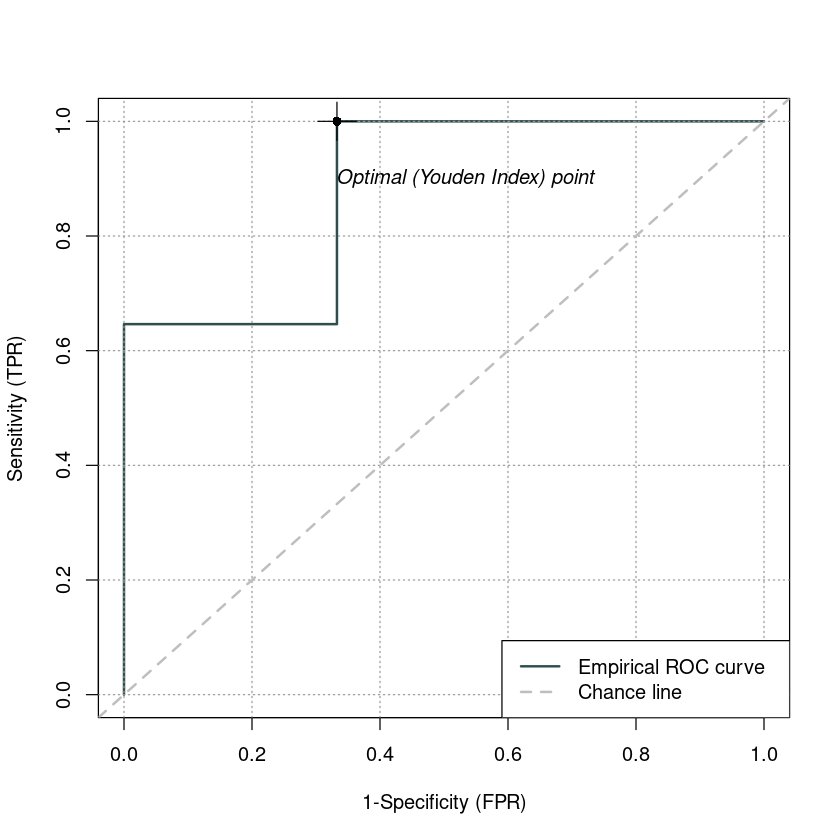

In [15]:
# ROC curve
ROCit_obj <- rocit(score = pred.demo,
                   class = test_data$gay)
plot(ROCit_obj)

measure <- measureit(score = pred.demo, class = test_data$gay,measure = c("ACC", "SENS", "FSCR"))
#names(measure)
plot(measure$ACC~measure$Cutoff, type = "l")

In [16]:
# AUC
ciAUC(ROCit_obj)

                                                          
   estimated AUC : 0.882306385107741                      
   AUC estimation method : empirical                      
                                                          
   CI of AUC                                              
   confidence level = 95%                                 
   lower = 0.870587052961824     upper = 0.894025717253658

xgbTree variable importance

  only 20 most important variables shown (out of 444)

                                                      Overall
age                                                    100.00
statussingle                                            96.20
height                                                  86.55
offspringdoesn&rsquo;t have kids                        44.64
offspringdoesn&rsquo;t want kids                        44.56
income                                                  33.81
offspringdoesn&rsquo;t have kids, but wants them        32.24
drugsnever                                              29.56
offspringhas kids                                       22.48
dietmostly anything                                     21.05
drugssometimes                                          19.52
body_typeathletic                                       19.22
educationworking on college/university                  17.12
offspringhas a kid                              

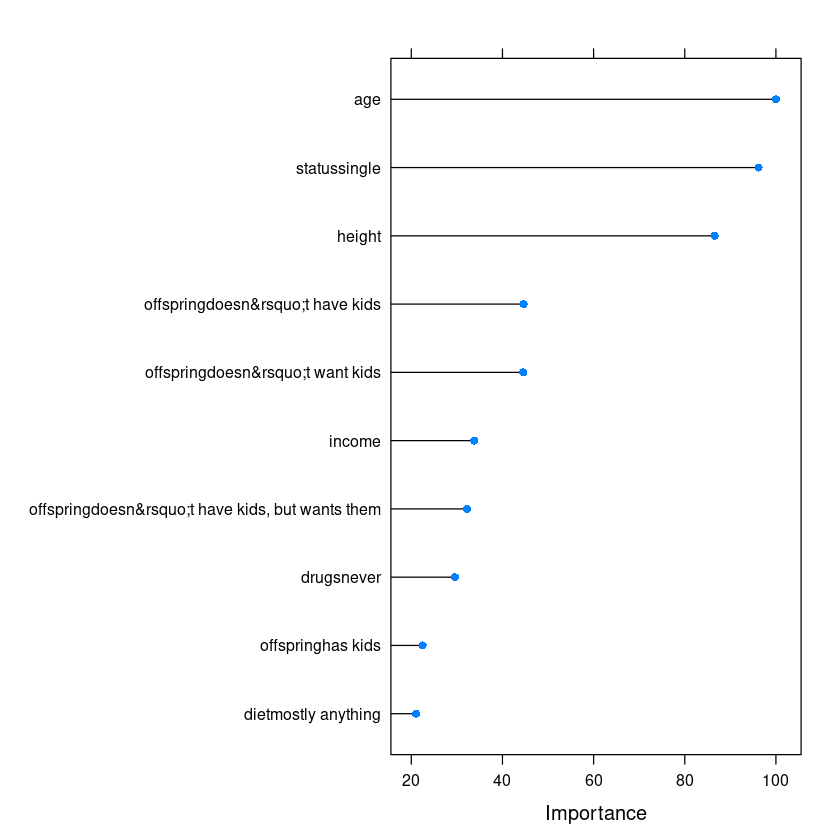

In [17]:
# feature importance
importance <- varImp(model.xgb.demo, scale=T)
print(importance)
plot(importance,10)

### use essay features only (there's no interpretations for these embeddings)

In [18]:
model.xgb.essay <- caret::train(as.factor(gay) ~ .,
                          data = select(train_data, gay, contains('V')),
                          method = "xgbTree",
                          trControl = trainControl(method = "none"),
                          tuneGrid=data.frame(
                              nrounds = 50,
                              max_depth = 2,
                              eta = 0.3,
                              gamma = 0,
                              colsample_bytree = 0.8,
                              min_child_weight = 1,
                              subsample = 1))

#with hyperparameter tunings 
model.xgb.essay <- caret::train(as.factor(gay) ~ .,
                          data = select(train_data, gay, contains('V')),
                          method = "xgbTree",
                          trControl = trainControl(method = "cv", 
                                                  number = 5, 
                                                  verboseIter = T),
                          verbose = 1)

In [19]:
pred.essay = predict(model.xgb.essay, test_data) %>% as.numeric - 1

In [ ]:
# confusion matrix
table(pred.essay, test_data$gay)

In [21]:
# accuracy
mean(pred.essay == test_data$gay)

[1] 0.5506595

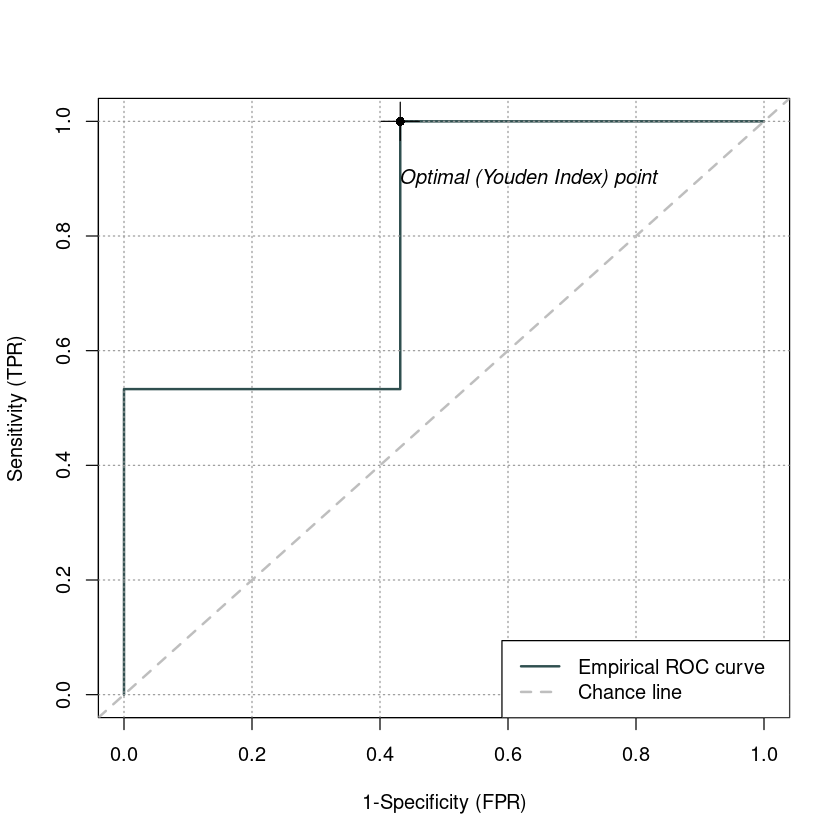

In [22]:
ROCit_obj <- rocit(score = as.numeric(pred.essay),
                   class = test_data$gay)
plot(ROCit_obj)

In [23]:
ciAUC(ROCit_obj)

                                                         
   estimated AUC : 0.798405879612856                     
   AUC estimation method : empirical                     
                                                         
   CI of AUC                                             
   confidence level = 95%                                
   lower = 0.783344619265833     upper = 0.81346713995988

measure <- measureit(score = pred.essay, class = test_data$gay,
                     measure = c("ACC", "SENS", "FSCR"))
names(measure)

plot(measure$ACC~measure$Cutoff, type = "l")

importance <- varImp(model.xgb.essay, scale=T)
#summarize importance
print(importance)
plot(importance,20)

### use both demo and essay 

In [39]:
model.xgb.both <- caret::train(as.factor(gay) ~ .,
                          data = select(train_data, - id, - sex),
                          method = "xgbTree",
                          trControl = trainControl(method = "none"),
                          tuneGrid=data.frame(
                              nrounds = 150,
                              max_depth = 1,
                              eta = 0.4,
                              gamma = 0,
                              colsample_bytree = 0.8,
                              min_child_weight = 1,
                              subsample = 1))

model.xgb.both <- caret::train(as.factor(gay) ~ .,
                          data = select(train_data, - id, - sex),
                          method = "xgbTree",
                          trControl = trainControl(method = "cv", 
                                                  number = 5, 
                                                  verboseIter = T))

In [40]:
pred.both = predict(model.xgb.both, test_data) %>% as.numeric - 1

In [41]:
# confusion matrix
table(pred.both, test_data$gay)

         
pred.both    0    1
        0 1100  621
        1  568 1047

In [42]:
# accuracy
mean(pred.both == test_data$gay)

[1] 0.6435851

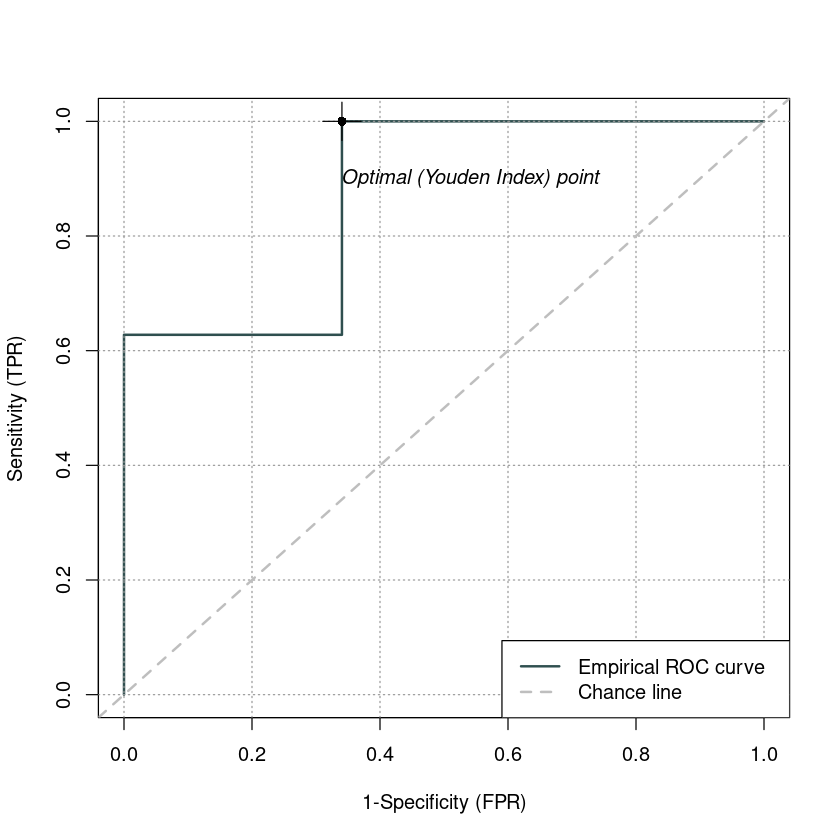

In [43]:
# ROC curve
ROCit_obj <- rocit(score = pred.both,
                   class = test_data$gay)
plot(ROCit_obj)

In [44]:
# AUC
ciAUC(ROCit_obj)

                                                          
   estimated AUC : 0.873220847782206                      
   AUC estimation method : empirical                      
                                                          
   CI of AUC                                              
   confidence level = 95%                                 
   lower = 0.861071636880035     upper = 0.885370058684376

xgbTree variable importance

  only 20 most important variables shown (out of 1212)

                                                 Overall
statussingle                                     100.000
offspringdoesn&rsquo;t want kids                  42.890
offspringdoesn&rsquo;t have kids                  42.542
offspringdoesn&rsquo;t have kids, but wants them  29.425
age                                               25.046
income                                            24.443
offspringhas kids                                 18.214
drugssometimes                                    17.938
dietmostly anything                               13.401
jobscience / tech / engineering                   12.300
offspringhas a kid                                12.251
educationworking on college/university            11.871
body_typeathletic                                  9.905
V248                                               8.965
smokesyes                                          8.919
eth

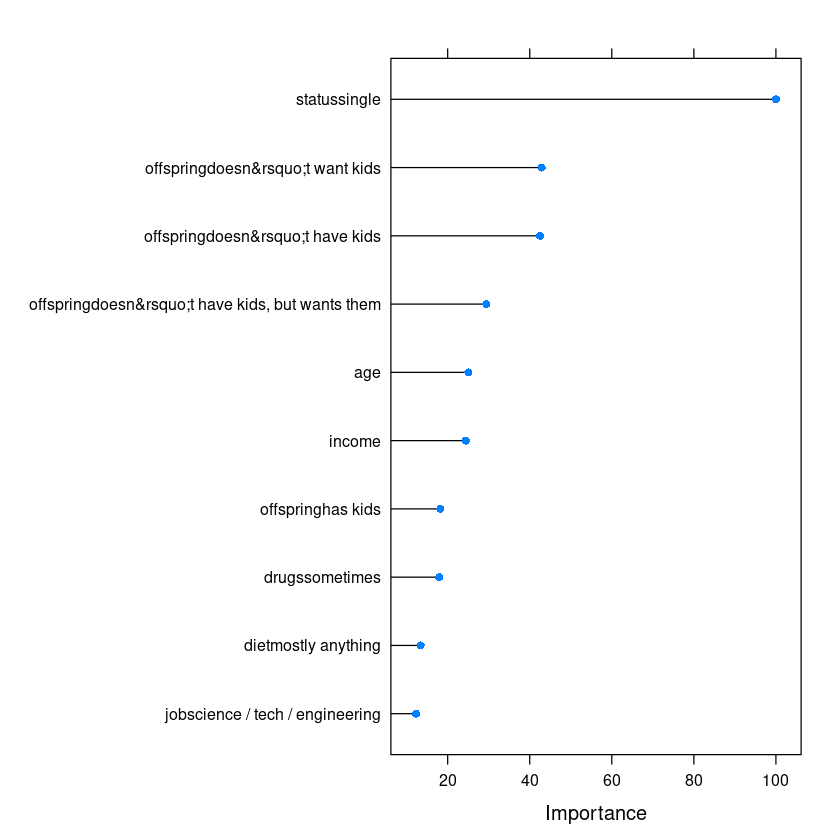

In [48]:
# feature importance
importance <- varImp(model.xgb.both, scale=T)
print(importance)
plot(importance,10)

m = matrix(,2,3)

colnames(m) = c('demo','essay','both')
rownames(m) = c('accuracy','AUC')

m[1,] = c(.66,.55,.64)
m[2,] = c(.88,.80,.87)

m